In [157]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import re
import warnings
warnings.filterwarnings('ignore')

In [158]:
# Read the data from input

df = pd.read_csv('train.csv')
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Any results you write to the current directory are saved as output.
df.head()

Year_Factor State_Factor building_class  \
0            1      State_1     Commercial   
1            1      State_1     Commercial   
2            1      State_1     Commercial   
3            1      State_1     Commercial   
4            1      State_1     Commercial   

                               facility_type  floor_area  year_built  \
0               Grocery_store_or_food_market     61242.0      1942.0   
1  Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                       Retail_Enclosed_mall    280025.0      1951.0   
3                  Education_Other_classroom     55325.0      1980.0   
4                  Warehouse_Nonrefrigerated     66000.0      1985.0   

   energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  ...  \
0                11.0        2.4                36              50.5  ...   
1                45.0        1.8                36              50.5  ...   
2                97.0        1.8                36              50.5  ...   
3                46.0        1.8                36              50.5  ...   
4               100.0        2.4                36              50.5  ...   

   days_above_80F  days_above_90F  days_above_100F  days_above_110F  \
0              14               0                0                0   
1              14               0                0                0   
2              14               0                0                0   
3              14               0                0                0   
4              14               0                0                0   

   direction_max_wind_speed  direction_peak_wind_speed  max_wind_speed  \
0                       1.0                        1.0             1.0   
1                       1.0                        NaN             1.0   
2                       1.0                        NaN             1.0   
3                       1.0                        NaN             1.0   
4                       1.0                        1.0             1.0   

   days_with_fog    site_eui  id  
0            NaN  248.682615   0  
1           12.0   26.500150   1  
2           12.0   24.693619   2  
3           12.0   48.406926   3  
4            NaN    3.899395   4  

[5 rows x 64 columns]

### Check Data Types

In [159]:
print(df.dtypes)

Year_Factor                    int64
State_Factor                  object
building_class                object
facility_type                 object
floor_area                   float64
                              ...   
direction_peak_wind_speed    float64
max_wind_speed               float64
days_with_fog                float64
site_eui                     float64
id                             int64
Length: 64, dtype: object


In [160]:
df.drop(["id"], axis=1, inplace=True)

In [161]:
df.shape

(75757, 63)

### Drop Duplicate rows

In [162]:
df.drop_duplicates(inplace=True)
df.shape

(75718, 63)

### Visualize all the missing data, the white lines are missing values

In [163]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df[missing_value_df.percent_missing != 0.0]

column_name  percent_missing
year_built                                year_built         2.399694
energy_star_rating                energy_star_rating        35.238649
direction_max_wind_speed    direction_max_wind_speed        54.240735
direction_peak_wind_speed  direction_peak_wind_speed        55.202198
max_wind_speed                        max_wind_speed        54.240735
days_with_fog                          days_with_fog        60.465147

In [164]:
col_high_missing = ['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
df = df.drop(col_high_missing,1)
df

Year_Factor State_Factor building_class  \
0                1      State_1     Commercial   
1                1      State_1     Commercial   
2                1      State_1     Commercial   
3                1      State_1     Commercial   
4                1      State_1     Commercial   
...            ...          ...            ...   
75752            6     State_11     Commercial   
75753            6     State_11    Residential   
75754            6     State_11     Commercial   
75755            6     State_11     Commercial   
75756            6     State_11    Residential   

                                   facility_type  floor_area  year_built  \
0                   Grocery_store_or_food_market     61242.0      1942.0   
1      Warehouse_Distribution_or_Shipping_center    274000.0      1955.0   
2                           Retail_Enclosed_mall    280025.0      1951.0   
3                      Education_Other_classroom     55325.0      1980.0   
4                      Warehouse_Nonrefrigerated     66000.0      1985.0   
...                                          ...         ...         ...   
75752                       Office_Uncategorized     20410.0      1995.0   
75753                        5plus_Unit_Building     40489.0      1910.0   
75754                           Commercial_Other     28072.0      1917.0   
75755                           Commercial_Other     53575.0      2012.0   
75756                         2to4_Unit_Building     23888.0      1974.0   

       energy_star_rating  ELEVATION  january_min_temp  january_avg_temp  ...  \
0                    11.0        2.4                36         50.500000  ...   
1                    45.0        1.8                36         50.500000  ...   
2                    97.0        1.8                36         50.500000  ...   
3                    46.0        1.8                36         50.500000  ...   
4                   100.0        2.4                36         50.500000  ...   
...                   ...        ...               ...               ...  ...   
75752                 8.0       36.6                28         43.451613  ...   
75753                98.0       36.6                28         43.451613  ...   
75754                 NaN       36.6                26         36.612903  ...   
75755                 NaN       36.6                26         36.612903  ...   
75756                51.0       36.6                27         36.935484  ...   

        avg_temp  days_below_30F  days_below_20F  days_below_10F  \
0      56.972603               0               0               0   
1      56.972603               0               0               0   
2      56.972603               0               0               0   
3      56.972603               0               0               0   
4      56.972603               0               0               0   
...          ...             ...             ...             ...   
75752  55.147541               6               0               0   
75753  55.147541               6               0               0   
75754  47.911202              26               2               0   
75755  47.911202              26               2               0   
75756  49.127397              17               1               0   

       days_below_0F  days_above_80F  days_above_90F  days_above_100F  \
0                  0              14               0                0   
1                  0              14               0                0   
2                  0              14               0                0   
3                  0              14               0                0   
4                  0              14               0                0   
...              ...             ...             ...              ...   
75752              0              25               3                0   
75753              0              25               3                0   
75754              0               6          

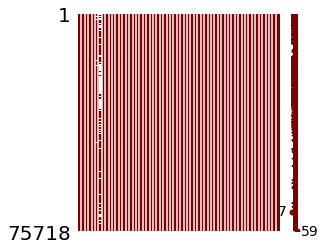

In [165]:
# search for missing data
import missingno as msno
msno.matrix(df, figsize=(4,4), color=(0.5,0,0))

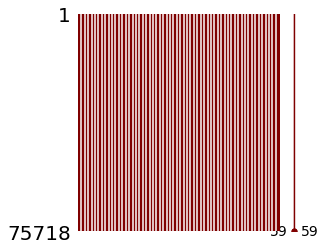

In [166]:
df = df.fillna(df.median())

# Visualize again
import missingno as msno
msno.matrix(df, figsize=(4,4), color=(0.5,0,0))

### Let's filling the missing data with the median value and drop feature columns with lots of missing data

### Lets see the correlations between features

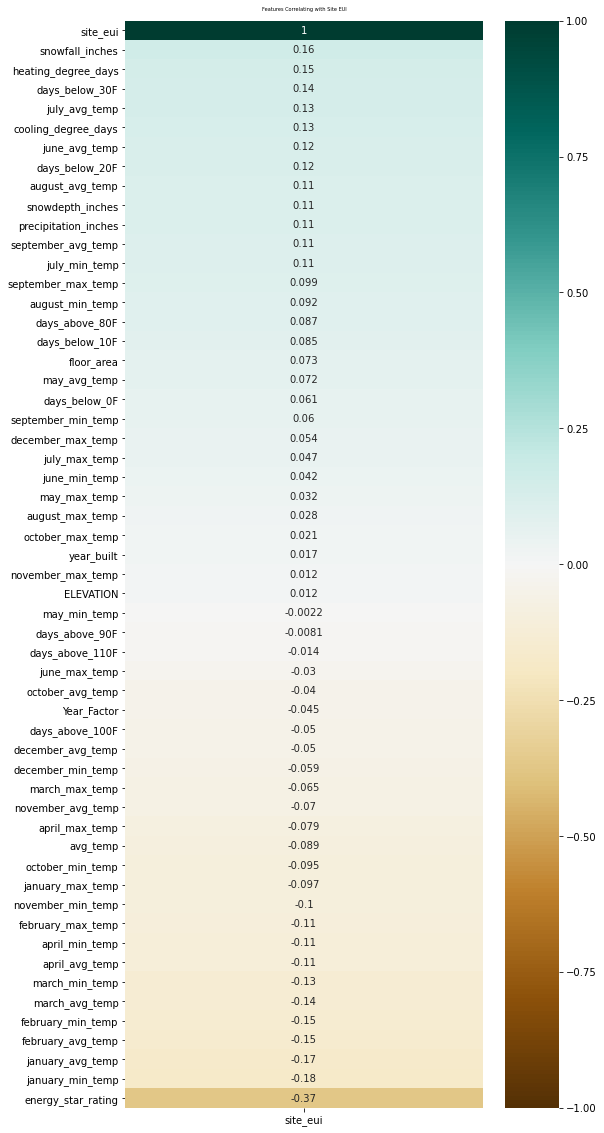

In [167]:
plt.figure(figsize=(8, 20))
heatmap = sns.heatmap(df.corr()[['site_eui']].sort_values(by='site_eui', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Site EUI', fontdict={'fontsize':5}, pad=10);

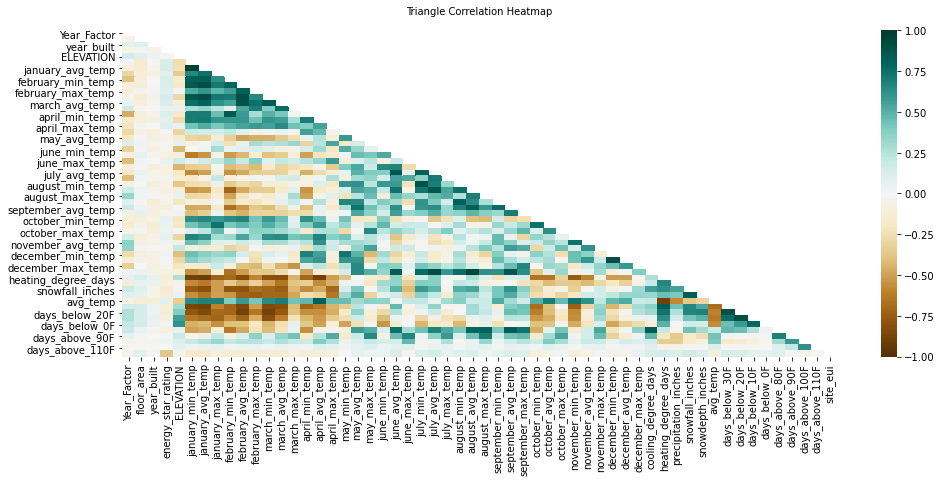

In [168]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':10}, pad=16);

In [169]:
def correlation(dataframe, threshold):
    high_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataframe.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and ((corr_matrix.columns[j], corr_matrix.columns[i]) not in high_corr):
                columns = (corr_matrix.columns[i], corr_matrix.columns[j]) # getting the name of the columns
                high_corr.add(columns)

    return high_corr

high_corr = correlation(df, 0.95)
print(high_corr)

{('january_avg_temp', 'january_min_temp'), ('cooling_degree_days', 'august_avg_temp')}


In [170]:
df.drop(columns=['january_min_temp'], 
        axis=1, inplace=True)

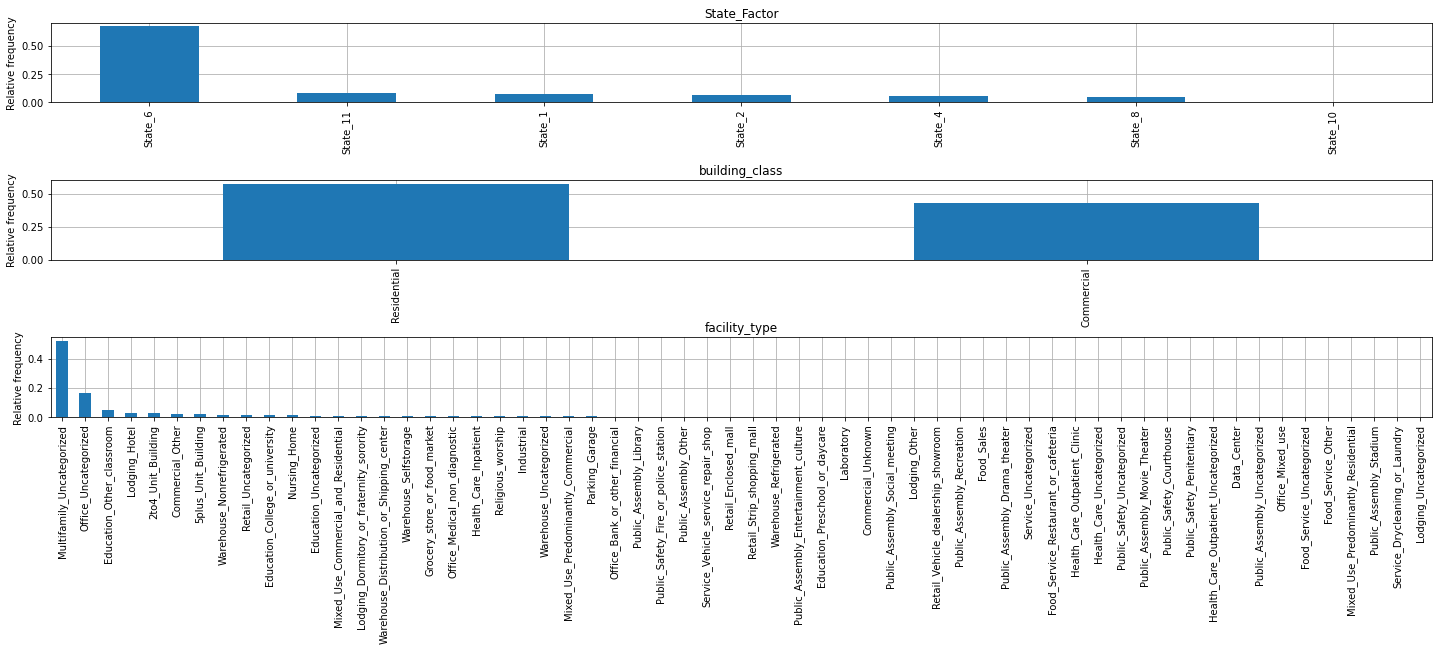

In [171]:
def plot_distbn(column, column_name, num):
    plt.subplot(num)
    column.value_counts(normalize=True).plot(kind='bar')
    plt.title(column_name)
    plt.ylabel('Relative frequency')
    plt.tight_layout()
    plt.grid(True)
    
    return column.value_counts(normalize=True)


plt.rcParams['axes.axisbelow'] = True
plt.figure(figsize=(20,6))
rel_freqs1 = plot_distbn(df['State_Factor'], 'State_Factor', 311)
rel_freqs2 = plot_distbn(df['building_class'], 'building_class', 312)
rel_freqs3 = plot_distbn(df['facility_type'], 'facility_type', 313)

In [172]:
df = df.drop('State_Factor',1)

In [173]:
significant = rel_freqs3.index[:6].tolist()
print(significant)

['Multifamily_Uncategorized', 'Office_Uncategorized', 'Education_Other_classroom', 'Lodging_Hotel', '2to4_Unit_Building', 'Commercial_Other']


In [174]:
df['facility_type'].loc[~df['facility_type'].isin(significant)] = 'Others'
df['facility_type'].loc[~df['facility_type'].isin(significant)] = 'Others'
df.head()

Year_Factor building_class              facility_type  floor_area  \
0            1     Commercial                     Others     61242.0   
1            1     Commercial                     Others    274000.0   
2            1     Commercial                     Others    280025.0   
3            1     Commercial  Education_Other_classroom     55325.0   
4            1     Commercial                     Others     66000.0   

   year_built  energy_star_rating  ELEVATION  january_avg_temp  \
0      1942.0                11.0        2.4              50.5   
1      1955.0                45.0        1.8              50.5   
2      1951.0                97.0        1.8              50.5   
3      1980.0                46.0        1.8              50.5   
4      1985.0               100.0        2.4              50.5   

   january_max_temp  february_min_temp  ...   avg_temp  days_below_30F  \
0                68                 35  ...  56.972603               0   
1                68                 35  ...  56.972603               0   
2                68                 35  ...  56.972603               0   
3                68                 35  ...  56.972603               0   
4                68                 35  ...  56.972603               0   

   days_below_20F  days_below_10F  days_below_0F  days_above_80F  \
0               0               0              0              14   
1               0               0              0              14   
2               0               0              0              14   
3               0               0              0              14   
4               0               0              0              14   

   days_above_90F  days_above_100F  days_above_110F    site_eui  
0               0                0                0  248.682615  
1               0                0                0   26.500150  
2               0                0                0   24.693619  
3               0                0                0   48.406926  
4               0                0                0    3.899395  

[5 rows x 57 columns]

In [175]:
for x in ['site_eui']:
    q75, q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
    
    ul = q75+(1.5*intr_qr)
    ll = q25-(1.5*intr_qr)
    
    df.loc[df[x]<ll,x] = np.nan
    df.loc[df[x]>ul,x] = np.nan

df['site_eui'].isnull().sum()

3845

In [176]:
df = df.dropna(axis = 0)

In [177]:
for col in df:
    if df[col].dtype != 'object':
        df[col] = (df[col]- df[col].min())/(df[col].max()-df[col].min())

In [178]:
enc = OrdinalEncoder()

for col in df:
    if df[col].dtype =='object':
        df[col] = enc.fit_transform(df[col].values.reshape(-1,1))

Training done using Random Forest


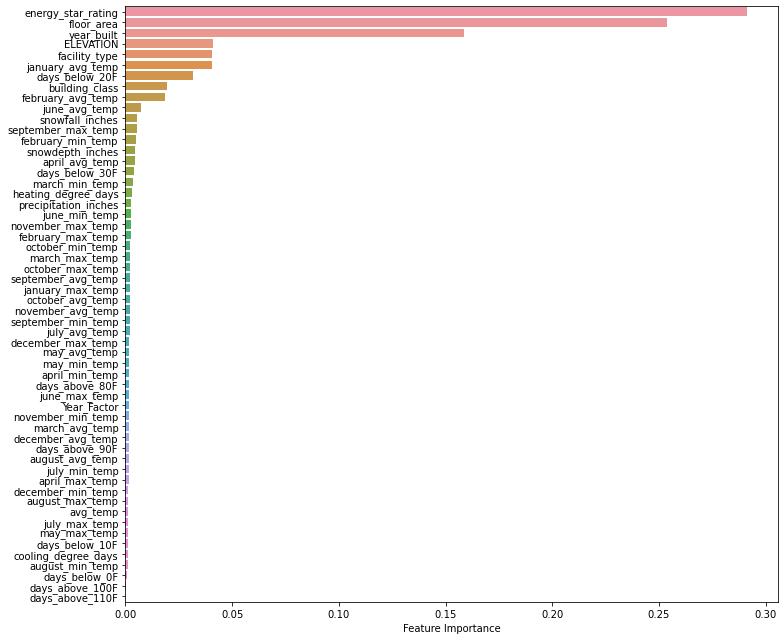

In [179]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(df.iloc[:,:-1], df['site_eui'])
print("Training done using Random Forest")

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking], y=df.iloc[:,:-1].columns.values[ranking], orient='h')
ax.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [180]:
df['SpringTemp'] = (df.march_avg_temp + df.april_avg_temp + df.may_avg_temp)/3
df['SummerTemp'] = (df.june_avg_temp + df.july_avg_temp + df.august_avg_temp)/3
df['FallTemp'] = (df.september_avg_temp + df.october_avg_temp + df.november_avg_temp)/3
df['WinterTemp'] = (df.december_avg_temp + df.january_avg_temp + df.february_avg_temp)/3

df['floorxBuilt'] = df.floor_area * df.year_built 
df['floorxEnergy'] = df.floor_area * df.energy_star_rating
df['floorxBuiltxEnergy'] = df.floor_area * df.year_built * df.energy_star_rating
df['floorxHeatCool'] = df.floor_area *(df.cooling_degree_days + df.heating_degree_days)

df["freezing_days"] = df.days_below_0F + df.days_below_10F
df["cold_days"] = df.days_below_20F + df.days_below_30F
df["warm_days"] = df.days_above_80F + df.days_above_90F
df["hot_days"] = df.days_above_100F + df.days_above_110F
    
df["floor_areaxenergy_star_rating"] = df.floor_area*df.energy_star_rating
df["floor_areaxELEVATION"] = df.floor_area*df.ELEVATION

df["snow_rain_inches"] = df.snowfall_inches + df.precipitation_inches

In [181]:
df = df.drop(['days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'days_above_110F','precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'january_avg_temp', 
         'january_max_temp', 'february_min_temp',
       'february_avg_temp', 'february_max_temp', 'march_min_temp',
       'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp',
       'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp',
       'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp',
       'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp',
       'august_max_temp', 'september_min_temp', 'september_avg_temp',
       'september_max_temp', 'october_min_temp', 'october_avg_temp',
       'october_max_temp', 'november_min_temp', 'november_avg_temp',
       'november_max_temp', 'december_min_temp', 'december_avg_temp',
       'december_max_temp', 'cooling_degree_days', 'heating_degree_days'],1)

In [182]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df['site_eui'], test_size=0.2, random_state=42)

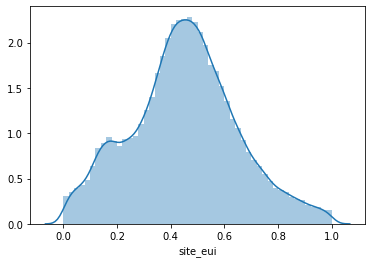

In [183]:
ax = sns.distplot(y_train)
plt.show()

In [184]:
X_train.columns

Index(['Year_Factor', 'building_class', 'facility_type', 'floor_area',
       'year_built', 'energy_star_rating', 'ELEVATION', 'avg_temp', 'site_eui',
       'SpringTemp', 'SummerTemp', 'FallTemp', 'WinterTemp', 'floorxBuilt',
       'floorxEnergy', 'floorxBuiltxEnergy', 'floorxHeatCool', 'freezing_days',
       'cold_days', 'warm_days', 'hot_days', 'floor_areaxenergy_star_rating',
       'floor_areaxELEVATION', 'snow_rain_inches'],
      dtype='object')

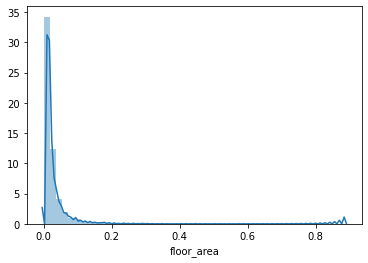

In [185]:
sns.distplot(X_train.floor_area)

In [207]:
X_train.floor_area = (X_train.floor_area)**(1/5)
X_test.floor_area = (X_test.floor_area)**(1/5)

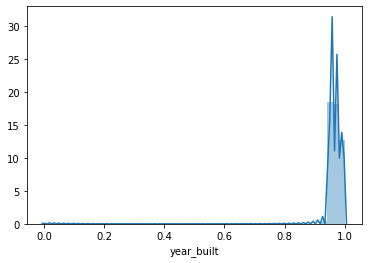

In [186]:
sns.distplot(X_train.year_built)

In [236]:
X_train.year_built = (0.5-X_train.year_built)**(8)
X_test.year_built = (0.5-X_test.year_built)**(8)

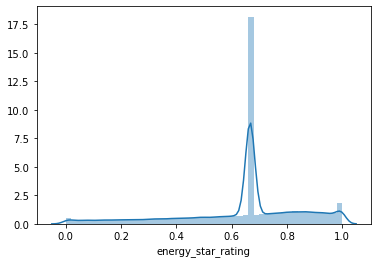

In [187]:
sns.distplot(X_train.energy_star_rating)

In [239]:
X_train.energy_star_rating = (X_train.energy_star_rating)**2
X_test.energy_star_rating = (X_test.energy_star_rating)**2

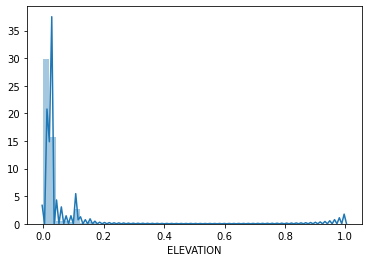

In [188]:
sns.distplot(X_train.ELEVATION)

In [241]:
X_train.ELEVATION = (X_train.ELEVATION)**(1/6)
X_test.ELEVATION = (X_test.ELEVATION)**(1/6)

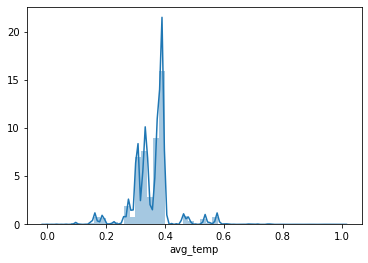

In [189]:
sns.distplot(X_train.avg_temp)

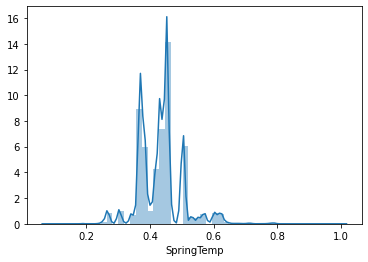

In [190]:
sns.distplot(X_train.SpringTemp)

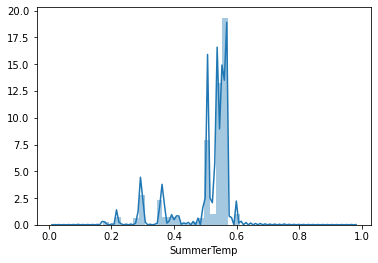

In [191]:
sns.distplot(X_train.SummerTemp)

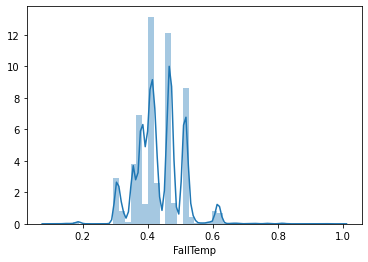

In [192]:
sns.distplot(X_train.FallTemp)

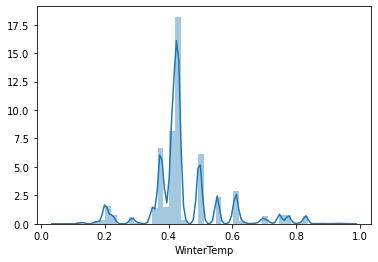

In [193]:
sns.distplot(X_train.WinterTemp)

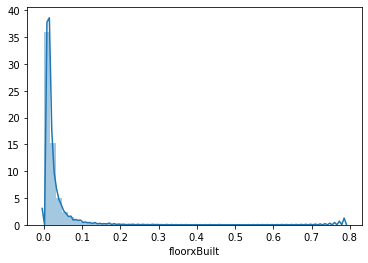

In [194]:
sns.distplot(X_train.floorxBuilt)

In [255]:
X_train.floorxBuilt = (X_train.floorxBuilt)**(1/6)
X_test.floorxBuilt = (X_test.floorxBuilt)**(1/6)

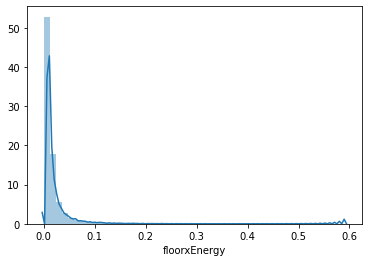

In [195]:
sns.distplot(X_train.floorxEnergy)

In [257]:
X_train.floorxEnergy = (X_train.floorxEnergy)**(1/6)
X_test.floorxEnergy = (X_test.floorxEnergy)**(1/6)

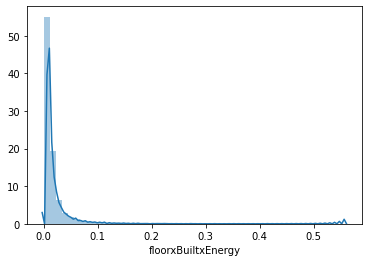

In [196]:
sns.distplot(X_train.floorxBuiltxEnergy)

In [259]:
X_train.floorxBuiltxEnergy = (X_train.floorxBuiltxEnergy)**(1/6)
X_test.floorxBuiltxEnergy = (X_test.floorxBuiltxEnergy)**(1/6)

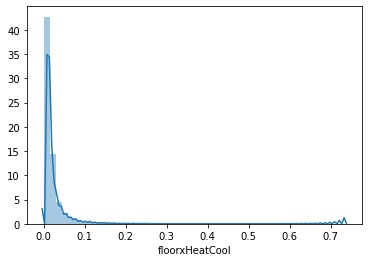

In [197]:
sns.distplot(X_train.floorxHeatCool)

In [261]:
X_train.floorxHeatCool = X_train.floorxHeatCool**(1/6)
X_test.floorxHeatCool = X_test.floorxHeatCool**(1/6)

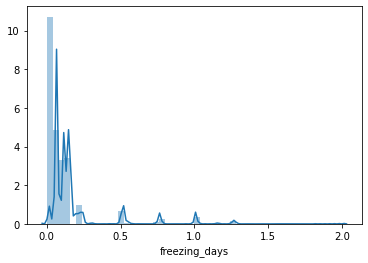

In [198]:
sns.distplot(X_train.freezing_days)

In [276]:
X_train.freezing_days = (X_train.freezing_days)**(1/5)
X_test.freezing_days = (X_test.freezing_days)**(1/5)

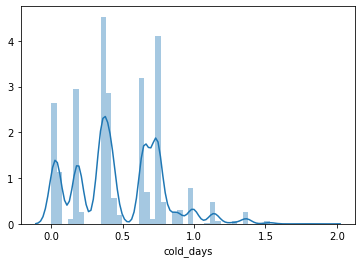

In [199]:
sns.distplot(X_train.cold_days)

In [278]:
X_train.cold_days = X_train.cold_days**(1/2)
X_test.cold_days = X_test.cold_days**(1/2)

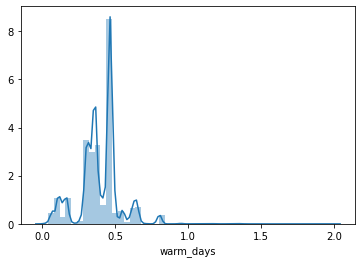

In [200]:
sns.distplot(X_train.warm_days)

In [281]:
X_train.warm_days = X_train.warm_days**(1/2)
X_test.warm_days = X_test.warm_days**(1/2)

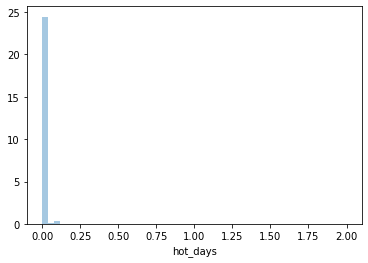

In [201]:
sns.distplot(X_train.hot_days)

In [285]:
X_train = X_train.drop('hot_days',1)
X_test = X_test.drop('hot_days',1)

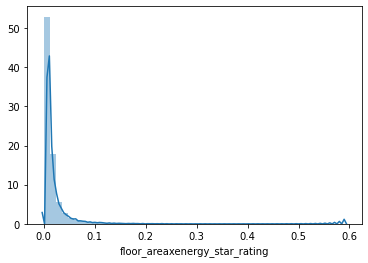

In [202]:
sns.distplot(X_train.floor_areaxenergy_star_rating)

In [288]:
X_train.floor_areaxenergy_star_rating = X_train.floor_areaxenergy_star_rating**(1/6)
X_test.floor_areaxenergy_star_rating = X_test.floor_areaxenergy_star_rating**(1/6)

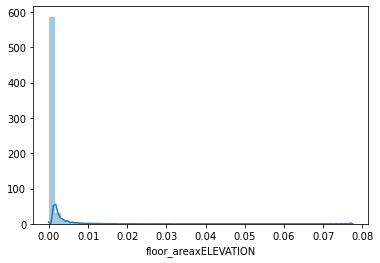

In [203]:
sns.distplot(X_train.floor_areaxELEVATION)

In [290]:
X_train.floor_areaxELEVATION = X_train.floor_areaxELEVATION**(1/6)
X_test.floor_areaxELEVATION = X_test.floor_areaxELEVATION**(1/6)

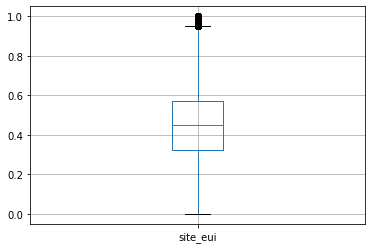

In [65]:
pd.DataFrame(y_train).boxplot()

## Ensembling

In [291]:
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('XGB', XGBRegressor()))
    level0.append(('SVR', SVR()))
    level0.append(('GBR', GradientBoostingRegressor()))
    level0.append(('CATB', CatBoostRegressor())),
    level0.append(('LGBM', LGBMRegressor()))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=10)
    return model

## Tuning Parameters

In [300]:
reg1 = XGBRegressor(random_state=42)
reg2 = SVR()
reg3 = GradientBoostingRegressor(random_state=42)
reg4 = CatBoostRegressor(random_state=42)
reg5 = LGBMRegressor()
#reg6 = get_stacking()

# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['regressor__n_estimators'] = [50, 100, 250]
param1['regressor__max_depth'] = [3, 6, 10]
param1['regressor__learning_rate'] = [0.01, 0.05, 0.1]
param1['regressor__colsample_bytree']: [0.3, 0.7]
param1['regressor'] = [reg1]

param2 = {}
#param2['regressor__kernel'] = ["rbf", "sigmoid", "poly"]
param2['regressor__C'] = [1, 1.5, 2, 2.5, 3]
param2['regressor'] = [reg2]

param3 = {}
param3['regressor__max_depth'] = [3,4,5]
param3['regressor__n_estimators'] = [100, 200, 300]
param3['regressor__learning_rate'] = [0.01, 0.05, 0.1]
param3['regressor'] = [reg3]

param4 = {}
param4['regressor__n_estimators'] = [500,1000,2000]
param4['regressor__learning_rate'] = [.001,0.01,.1]
param4['regressor__max_depth'] = [1,2,4]
param4['regressor__subsample'] = [.5,.75,1]
param4['regressor'] = [reg4]

param5 = {}
param5['regressor__num_leaves'] = [200,300,500]
param5['regressor__learning_rate'] = [.001,0.01,.1]
param5['regressor__feature_fraction'] = [0.3,0.6,0.9]
param5['regressor__bagging_freq'] = [50,70,90]
param5['regressor'] = [reg5]

pipeline = Pipeline([('regressor', reg3)])
params = [param1, param2, param3, param4, param5]

In [ ]:
rs = RandomizedSearchCV(pipeline, param3, cv=5, scoring='neg_mean_squared_error')
rs.fit(X_train, y_train)

In [ ]:
rs.best_params_

In [ ]:
rs.best_score_

## Model Validation

In [57]:
def run_exps(X_train, y_train, X_test, y_test) -> pd.DataFrame:
    
    dfs = []
    models = [
          ('XGB', XGBRegressor(n_estimators = 250, max_depth = 6, learning_rate = 0.05)), 
          ('SVR', SVR(C = 3)),
          ('CATB', CatBoostRegressor()),
          ('LGBM', LGBMRegressor(num_leaves = 300, learning_rate = 0.1, feature_fraction = 0.9, bagging_freq = 70)),
          ('GBR', GradientBoostingRegressor()),
          ('Stack', get_stacking())]
    results = []
    names = []
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

    for name, model in models:
        kfold = model_selection.RepeatedKFold(n_splits=5, n_repeats = 3, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(mean_squared_error(y_test, y_pred, squared = False))
        
        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

        final = pd.concat(dfs, ignore_index=True)

    return final

In [ ]:
final = run_exps(X_train, y_train, X_test, y_test)

XGB
0.14000319561304267
SVR
0.15229552147423372
GBR
0.1494319161519065
Learning rate set to 0.07879
0:	learn: 0.1928849	total: 80.9ms	remaining: 1m 20s
1:	learn: 0.1881987	total: 89.4ms	remaining: 44.6s
2:	learn: 0.1840762	total: 99.8ms	remaining: 33.2s
3:	learn: 0.1804235	total: 110ms	remaining: 27.3s
4:	learn: 0.1773154	total: 118ms	remaining: 23.4s
5:	learn: 0.1743685	total: 124ms	remaining: 20.6s
6:	learn: 0.1719697	total: 133ms	remaining: 18.9s
7:	learn: 0.1697508	total: 139ms	remaining: 17.3s
8:	learn: 0.1677200	total: 145ms	remaining: 16s
9:	learn: 0.1660231	total: 151ms	remaining: 14.9s
10:	learn: 0.1644655	total: 157ms	remaining: 14.1s
11:	learn: 0.1632009	total: 163ms	remaining: 13.4s
12:	learn: 0.1620080	total: 168ms	remaining: 12.8s
13:	learn: 0.1608652	total: 174ms	remaining: 12.3s
14:	learn: 0.1598271	total: 180ms	remaining: 11.8s
15:	learn: 0.1588719	total: 186ms	remaining: 11.4s
16:	learn: 0.1580668	total: 191ms	remaining: 11.1s
17:	learn: 0.1573378	total: 197ms	remaini

In [ ]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by different metrics')
#plt.savefig('./benchmark_models_performance.png',dpi=300)

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
#plt.savefig('./benchmark_models_time.png',dpi=300)

In [ ]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

In [ ]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

## Prediction Interval Score

In [ ]:
def intervalScore(predObj,actual,level):
    n = len(predObj)
    alpha = 1 - level
    ilow = (actual<predObj.iloc[:,2])
    ihigh = (actual>predObj.iloc[:,3])
    sumlength = sum(predObj.iloc[:,3]-predObj.iloc[:,2])
    sumlow = sum(predObj.iloc[ilow,2]-actual.iloc[ilow])*2/alpha
    sumhigh = sum(actual.iloc[ihigh]-predObj.iloc[ihigh,3])*2/alpha
    avglength = sumlength/n
    IS = (sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover = mean(actual>= predObj.iloc[,2] & actual<=predObj.iloc[,3])
    summ = [level,avglength,IS,cover]
    #imiss = which(ilow | ihigh)
    return summ